In [89]:
import torch
import torchvision
import pandas as pd
from sklearn.datasets import load_boston

# DATASET

In [145]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

#temp_dataset = fetch_openml('mnist_784')
temp_dataset = load_boston()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [146]:
data, target = temp_dataset.data, temp_dataset.target
#data, target = temp_dataset.data.to_numpy(), temp_dataset.target.to_numpy(dtype="float")

from sklearn import preprocessing
data = preprocessing.StandardScaler().fit_transform(data)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [148]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class TensorDataset(Dataset):
  def __init__(self, data, target):
    self.data = data 
    self.target = target
  
  def __len__(self):
    return len(self.target)
  
  def __getitem__(self, idx):
    return torch.FloatTensor(self.data[idx]), \
    torch.FloatTensor([self.target[idx]])

In [149]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# HIGH CODE

In [150]:
from torch import nn

class Model1(nn.Module):
  def __init__(self):
    super(Model1, self).__init__()
    self.hidden1 = nn.Linear(13, 100)
    self.activate1 = nn.ReLU()
    self.last = nn.Linear(100,1)
  
  def forward(self, x):
    out = self.hidden1(x)
    out = self.activate1(out)
    out = self.last(out)
    return out

In [223]:
model = Model1()

In [224]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [225]:
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer, \
                                              lr_lambda=lambda epoch: 0.95 ** epoch)

In [226]:
loss_fn = torch.nn.MSELoss()

In [227]:
def test_eval(test_dataloader, model, loss_fn):
  cost = 0.
  for X, y in test_dataloader:
    model.eval()
    with torch.no_grad():
      pred = model.forward(X)
      temp_cost = loss_fn(y, pred)
      cost += temp_cost
  cost /= len(test_dataloader)
  return cost

In [228]:
test_cost = test_eval(train_dataloader, model, loss_fn)
print(test_cost)

tensor(605.0253)


In [229]:
epochs = 100
train_losses = []
val_losses = []
lrs = []
for epoch in range(epochs):
  temp_cost = 0.
  for X, y in train_dataloader:
    model.train()
    y = y.reshape(-1, 1)
    optimizer.zero_grad()
    out = model.forward(X)
    cost = loss_fn(y, out)
    temp_cost += cost.item()
    cost.backward()
    optimizer.step()
  temp_cost /= len(train_dataloader)
  train_losses.append(temp_cost)
  temp_cost = 0.
  for X, y in val_dataloader:
    model.eval()
    with torch.no_grad():
      y = y.reshape(-1, 1)
      out = model.forward(X)
      cost = loss_fn(y, out)
      temp_cost += cost.item()
  temp_cost /= len(val_dataloader)
  val_losses.append(temp_cost)
  lrs.append(optimizer.param_groups[0]['lr'])
  scheduler.step()

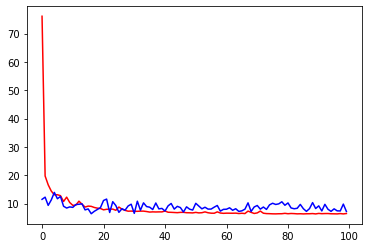

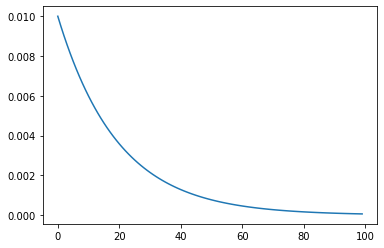

In [230]:
import matplotlib.pyplot as plt

plt.plot(train_losses, c="red")
plt.plot(val_losses, c="blue")
plt.show()

plt.plot(lrs)
plt.show()

In [231]:
test_cost = test_eval(train_dataloader, model, loss_fn)
print(test_cost)

tensor(6.3049)


# LOW CODE

In [196]:
def relu(x):
  out = torch.zeros_like(x)
  out[x >= 0] = x[x >= 0]
  return out

In [197]:
def forward(X, W1, b1, W2, b2):
    out = torch.matmul(X, W1) + b1
    out = relu(out)
    #out = torch.sigmoid(out)
    out = torch.matmul(out, W2) + b2
    return out

In [198]:
def test_proc(test_dataloader, W1, b1, W2, b2):
  temp_cost = 0.
  for X, y in test_dataloader:
    with torch.no_grad():
      out = forward(X, W1, b1, W2, b2)
      cost = torch.mean((out - y) ** 2)
      temp_cost += cost.item()
  temp_cost /= len(test_dataloader)
  return temp_cost

In [204]:
W1 = torch.randn((13, 50), requires_grad=True)
b1 = torch.zeros(50, requires_grad=True)

W2 = torch.randn((50, 1), requires_grad=True)
b2 = torch.zeros(1, requires_grad=True)

In [205]:
test_cost = test_proc(test_dataloader, W1, b1, W2, b2)
print(f"TEST COST : {test_cost:>7.3f}")

TEST COST : 529.950


In [206]:
epochs = 100 
learning_rate = 0.01
train_losses = []
val_losses = []
for epoch in range(epochs):
  ## Validate test
  temp_cost = 0.
  for X, y in val_dataloader:
    # step1: forward (get Hypothesis)
    with torch.no_grad():
      out = forward(X, W1, b1, W2, b2)
      cost = torch.mean((out - y) ** 2)
      temp_cost += cost.item()
  temp_cost /= len(val_dataloader)
  val_losses.append(temp_cost)

  ## Train course
  temp_cost = 0.
  for X, y in train_dataloader:
    # step1: forward (get Hypothesis)
    out = forward(X, W1, b1, W2, b2)
    # step2: Cost function
    cost = torch.mean((out - y) ** 2)
    temp_cost += cost.item()
    # step3: Backward
    cost.backward()

    # step4: Update parameters
    W1.data -= learning_rate * W1.grad
    b1.data -= learning_rate * b1.grad
    W2.data -= learning_rate * W2.grad
    b2.data -= learning_rate * b2.grad

    # step5: extra step
    W1.grad, b1.grad, W2.grad, b2.grad = [None] * 4
  
  temp_cost /= len(train_dataloader)
  train_losses.append(temp_cost)

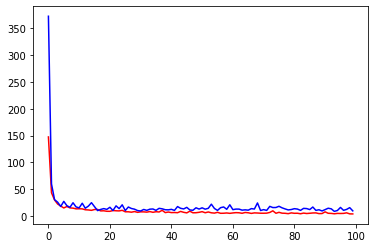

In [207]:
import matplotlib.pyplot as plt

plt.plot(train_losses, c="red")
plt.plot(val_losses, c="blue")

In [208]:
test_cost = test_proc(train_dataloader, W1, b1, W2, b2)
print(f"TEST COST : {test_cost:>7.3f}")

TEST COST :   6.147
